# Flowers Classification with Transfer Learning

## Project Setup

Import libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Preparation

Load the dataset, rescale, then split into training and validation set

In [2]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)

training_set = image_generator.flow_from_directory(batch_size=32,
                                                   directory="datasets/",
                                                   shuffle=False,
                                                   target_size=(180, 180),
                                                   subset="training",
                                                   class_mode="categorical")

validation_set = image_generator.flow_from_directory(batch_size=32,
                                                   directory="datasets/",
                                                   shuffle=False,
                                                   target_size=(180, 180),
                                                   subset="validation",
                                                   class_mode="categorical")

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


Show images for the first batch

In [3]:
class_names = list(training_set.class_indices)
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

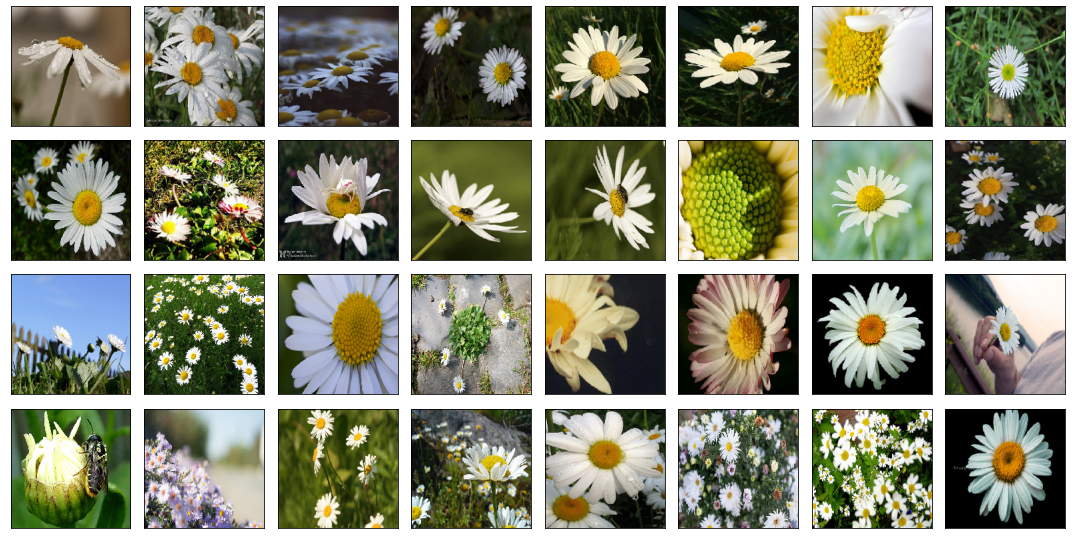

In [4]:
fig = plt.figure(figsize=(15, 15))

batch_1_img = training_set[0]
for i in range(32):
    digit = batch_1_img[0][i]
    #label = class_names[int(batch_1_img[1][i])]
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digit, cmap=plt.cm.binary)
    #ax.set_title(str(label), backgroundcolor='white', fontsize=10)
plt.tight_layout()

## Model Training

In [6]:
model = Sequential()
inceptionv3_model = InceptionV3(input_shape=(180,180,3), 
                    weights='imagenet',
                    pooling='avg',classes=5,
                    include_top=False)

for layer in inceptionv3_model.layers:
    layer.trainable = False
    
model.add(inceptionv3_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

* include_top=False is used so that we can add custom input and output layers according to the data we are currently using
* use imagenet weight
* layer.trainable = False so that the model doesnt re-learning the weight, save time

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 22,854,437
Trainable params: 1,051,653
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(training_set, validation_data=validation_set, epochs=10)

Epoch 1/10
92/92 [==============================] - 19s 126ms/step - loss: 3.3313 - accuracy: 0.5019 - val_loss: 1.1146 - val_accuracy: 0.5499
Epoch 2/10
92/92 [==============================] - 9s 92ms/step - loss: 0.8154 - accuracy: 0.6754 - val_loss: 0.6545 - val_accuracy: 0.7633
Epoch 3/10
92/92 [==============================] - 9s 92ms/step - loss: 0.6975 - accuracy: 0.7213 - val_loss: 0.9984 - val_accuracy: 0.5882
Epoch 4/10
92/92 [==============================] - 9s 96ms/step - loss: 0.5971 - accuracy: 0.7829 - val_loss: 0.7195 - val_accuracy: 0.7373
Epoch 5/10
92/92 [==============================] - 9s 97ms/step - loss: 0.5639 - accuracy: 0.7870 - val_loss: 0.5182 - val_accuracy: 0.8085
Epoch 6/10
92/92 [==============================] - 9s 96ms/step - loss: 0.4564 - accuracy: 0.8343 - val_loss: 0.6001 - val_accuracy: 0.7647
Epoch 7/10
92/92 [==============================] - 9s 97ms/step - loss: 0.4383 - accuracy: 0.8418 - val_loss: 0.5259 - val_accuracy: 0.8085
Epoch 8/10


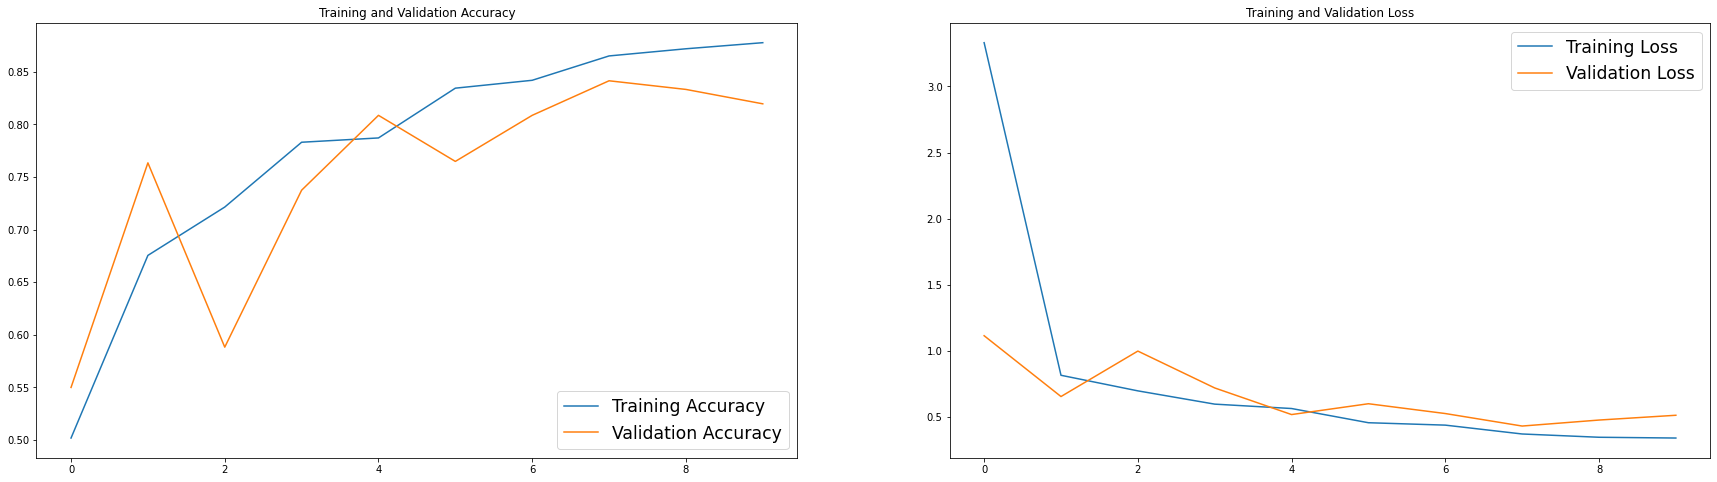

In [9]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right', fontsize="xx-large")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right', fontsize="xx-large")
plt.title('Training and Validation Loss')
plt.show()

In [10]:
loss, accuracy = model.evaluate(training_set)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

92/92 [==============================] - 7s 77ms/step - loss: 0.3559 - accuracy: 0.8602
Loss:  0.3558669090270996
Accuracy:  0.8601565361022949


In [11]:
training_pred = np.argmax(model.predict(training_set), axis=1)

92/92 [==============================] - 8s 73ms/step


In [12]:
training_pred

array([0, 0, 0, ..., 2, 2, 4], dtype=int64)

In [13]:
training_set.classes

array([0, 0, 0, ..., 4, 4, 4])

In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
print(confusion_matrix(training_set.classes, training_pred))

[[439  21  34   1  12]
 [  8 684  14   4   9]
 [  1   2 499   4   7]
 [ 19  41  91 401   8]
 [  1   3 128   3 505]]


In [16]:
y_pred = np.argmax(model.predict(validation_set), axis=1)

23/23 [==============================] - 2s 73ms/step


In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
print(confusion_matrix(validation_set.classes, y_pred))

[[110   6   8   1   1]
 [  3 158   9   5   4]
 [  1   1 123   0   3]
 [  2  17  23  92   5]
 [  0   1  38   4 116]]
